# Dataset ARPAV
Registrazione delle misure recuperate dal database di ARPA Veneto

In [82]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(tsibble, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(sf, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(assertr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source("notebooks/integrazioni_regionali/nb_tools/state_avail.R")
source("notebooks/integrazioni_regionali/nb_tools/pairing_procedure.R")
source("src/load/load.R")
source("src/analysis/data/clim_availability.R")
source("src/analysis/data/quality_check.R")
source("src/pairing/analysis.R")
source("src/pairing/matching.R")
source("src/pairing/plots.R")
source("src/pairing/combining.R")
source("src/pairing/displaying.R")
source("src/plot/plot_helpers.R")
source("src/database/write.R")
source("src/database/open.R")
source("src/database/test.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")


In [5]:
dataset_id <- "ARPAV"
state <- "Veneto"
path.veneto <- file.path(path.ds, "ARPA", "VENETO", "Dati_ARPAV_STAZIONI_AUTOMATICHE_al_02_02_2022")
path.tmin <- file.path(path.veneto, "ARPAV_Tmin.csv")
path.tmax <- file.path(path.veneto, "ARPAV_Tmax.csv")


## Caricamento da frammenti

In [36]:
load_original_table <- function(path, variable) {
    tab <- vroom(path.tmin, n_max = 8L, col_names = FALSE, show_col_types = FALSE) |> select(!X2:X4)
    col_names <- tab$X1
    ntab <- tab |>
        select(-X1) |>
        t()
    colnames(ntab) <- col_names
    # The stations crs is EPSG:3003 (probably)
    stations <- as_tibble(ntab) |>
        rename(original_id = statcd, station_name = statnm, elevation = altitude, province = provsgl, start_date = iniziovalidita, end_date = finevalidita) |>
        mutate(
            start_date = as.Date(start_date),
            end_date = na_if(end_date, "attiva") |> as.Date(),
            across(c(xkmpos, ykmpos, elevation), as.numeric),
            network = "ARPAV",
            state = state,
            dataset_id = dataset_id
        ) |>
        name_stations() |>
        assert(is_uniq, station_id) |>
        mutate(coords = sf_project(from = "EPSG:3003", to = "EPSG:4326", pick(xkmpos, ykmpos), authority_compliant = FALSE), lon = coords[, 1], lat = coords[, 2]) |>
        select(-coords)

    data <- vroom(path.tmin, skip = 9L, col_names = c("date", "year", "month", "day", stations$original_id), show_col_types = FALSE) |>
        select(!c(year, month, day)) |>
        pivot_longer(cols = !date, names_to = "original_id") |>
        drop_na() |>
        filter(between(date, first_date, last_date)) |>
        arrange(as.numeric(original_id), date) |>
        mutate(merged = FALSE)

    series <- data |>
        distinct(original_id) |>
        mutate(variable = variable, qc_step = 0L) |>
        left_join(stations |> select(original_id, station_id), by = "original_id", relationship = "one-to-one") |>
        name_series(dataset_id) |>
        assert(is_uniq, series_id) |>
        assert(not_na, everything())

    # Effectively filtering out stations that provide old data
    stations <- stations |> semi_join(series, by = "station_id")

    # Associating series_id to data
    data <- data |>
        left_join(series, by = "original_id", relationship = "many-to-one") |>
        select(all_of(data_schema$names))

    # Asserting that every station has a series and vice versa
    full_join(stations, series, by = "station_id", relationship = "one-to-one") |>
        assert(not_na, c(network, variable))

    list(stations, series, data)
}

load_original_dataset <- function() {
    tmin <- load_original_table(path.tmin, "T_MIN")
    tmax <- load_original_table(path.tmax, "T_MAX")

    # Station identifiers point to the same station and there are no exceedings of stations
    full_join(tmin[[1]], tmax[[1]], by = "original_id") |>
        verify(station_name.x == station_name.y) |>
        verify(station_id.x == station_id.y) |>
        verify(lon.x == lon.y) |>
        verify(lat.x == lat.y) |>
        assert(not_na, starts_with("station_name"))

    # Asserting that every station has two series
    series <- bind_rows(tmin[[2]], tmax[[2]]) |>
        assert(not_na, everything()) |>
        assert(is_uniq, series_id)
    series |>
        group_by(station_id) |>
        tally() |>
        verify(n == 2)

    data <- bind_rows(tmin[[3]], tmax[[3]])

    list(tmin[[1]], series, data)
}


In [39]:
c(st, se, d) %<-% load_original_dataset()


In [40]:
write_station_metadata(st, dataset_id, auto_complete = FALSE, provisional = FALSE)
write_series_metadata(se, dataset_id = paste0(dataset_id, "_raw"), auto_complete = FALSE, provisional = TRUE)
write_data(d, paste0(dataset_id, "_raw"), provisional = TRUE)


## Metadati
Produco le tabelle dei metadati del dataset e delle stazioni. Controllo con `assertr` e `tsibble` la consistenza delle tabelle.

### Dataset
| dataset_id | entity | reference | 
|------------|--------|-----------|
| utf8()     | utf8() | utf8()    |
| pkey       | obs    | obs       |

### Stazioni
| station_id | station_name | network | state | geometa | dataset_id | original_id |
|------------|--------------|---------|-------|---------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|         | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   |         | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "additional_meta" alla quale puntare con un riferimento

### Serie
| series_id | station_id  | variable | qc_step | merged_from |
|-----------|-------------|----------|---------|-------------|



## Dati
Produco la tabella delle misure. Il formato è row-records:

|series_id|date|value|merged|
|---------|----|-----|------|
|utf8()|date()|float()|bool()|
| fkey    |obs | obs | obs  |

Note:
- `merged` indica se il valore in riga è risultato di un merge. Le caratteristiche del merge sono riportate nella tabella delle stazioni.

Effettuare controllo qualità

In [41]:
qc_data <- open_data(paste0(dataset_id, "_raw"), provisional = TRUE) |>
    gross_errors_check(value) |>
    group_by(series_id) |>
    collect() |>
    repeated_values_check() |>
    integer_streak_check() |>
    ungroup() |>
    filter(!(qc_gross | qc_repeated | qc_int_streak)) |>
    select(!starts_with("qc")) |>
    arrange(series_id)


In [42]:
qc_data |>
    group_by(series_id) |>
    repeated_fraction_check() |>
    filter(qc_repeated_fraction >= 0.1)


series_id,qc_repeated_fraction
<chr>,<dbl>


In [43]:
qc_data |>
    group_by(series_id) |>
    integers_fraction_check() |>
    filter(qc_integer_fraction >= 0.2)


series_id,qc_integer_fraction
<chr>,<dbl>


In [44]:
c(data, series) %<-% (qc_data |>
    left_join(
        read_series_metadata(paste0(dataset_id, "_raw"), provisional = TRUE) |> collect(),
        by = "series_id"
    ) |>
    mutate(qc_step = 1L) |>
    name_series(dataset_id) |>
    split_data_metadata()
)


In [45]:
data |> write_data(dataset_id = paste0(dataset_id, "_qc"), provisional = TRUE)
series |> write_series_metadata(dataset_id = paste0(dataset_id, "_qc"), auto_complete = FALSE, provisional = TRUE)


## Analisi disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese

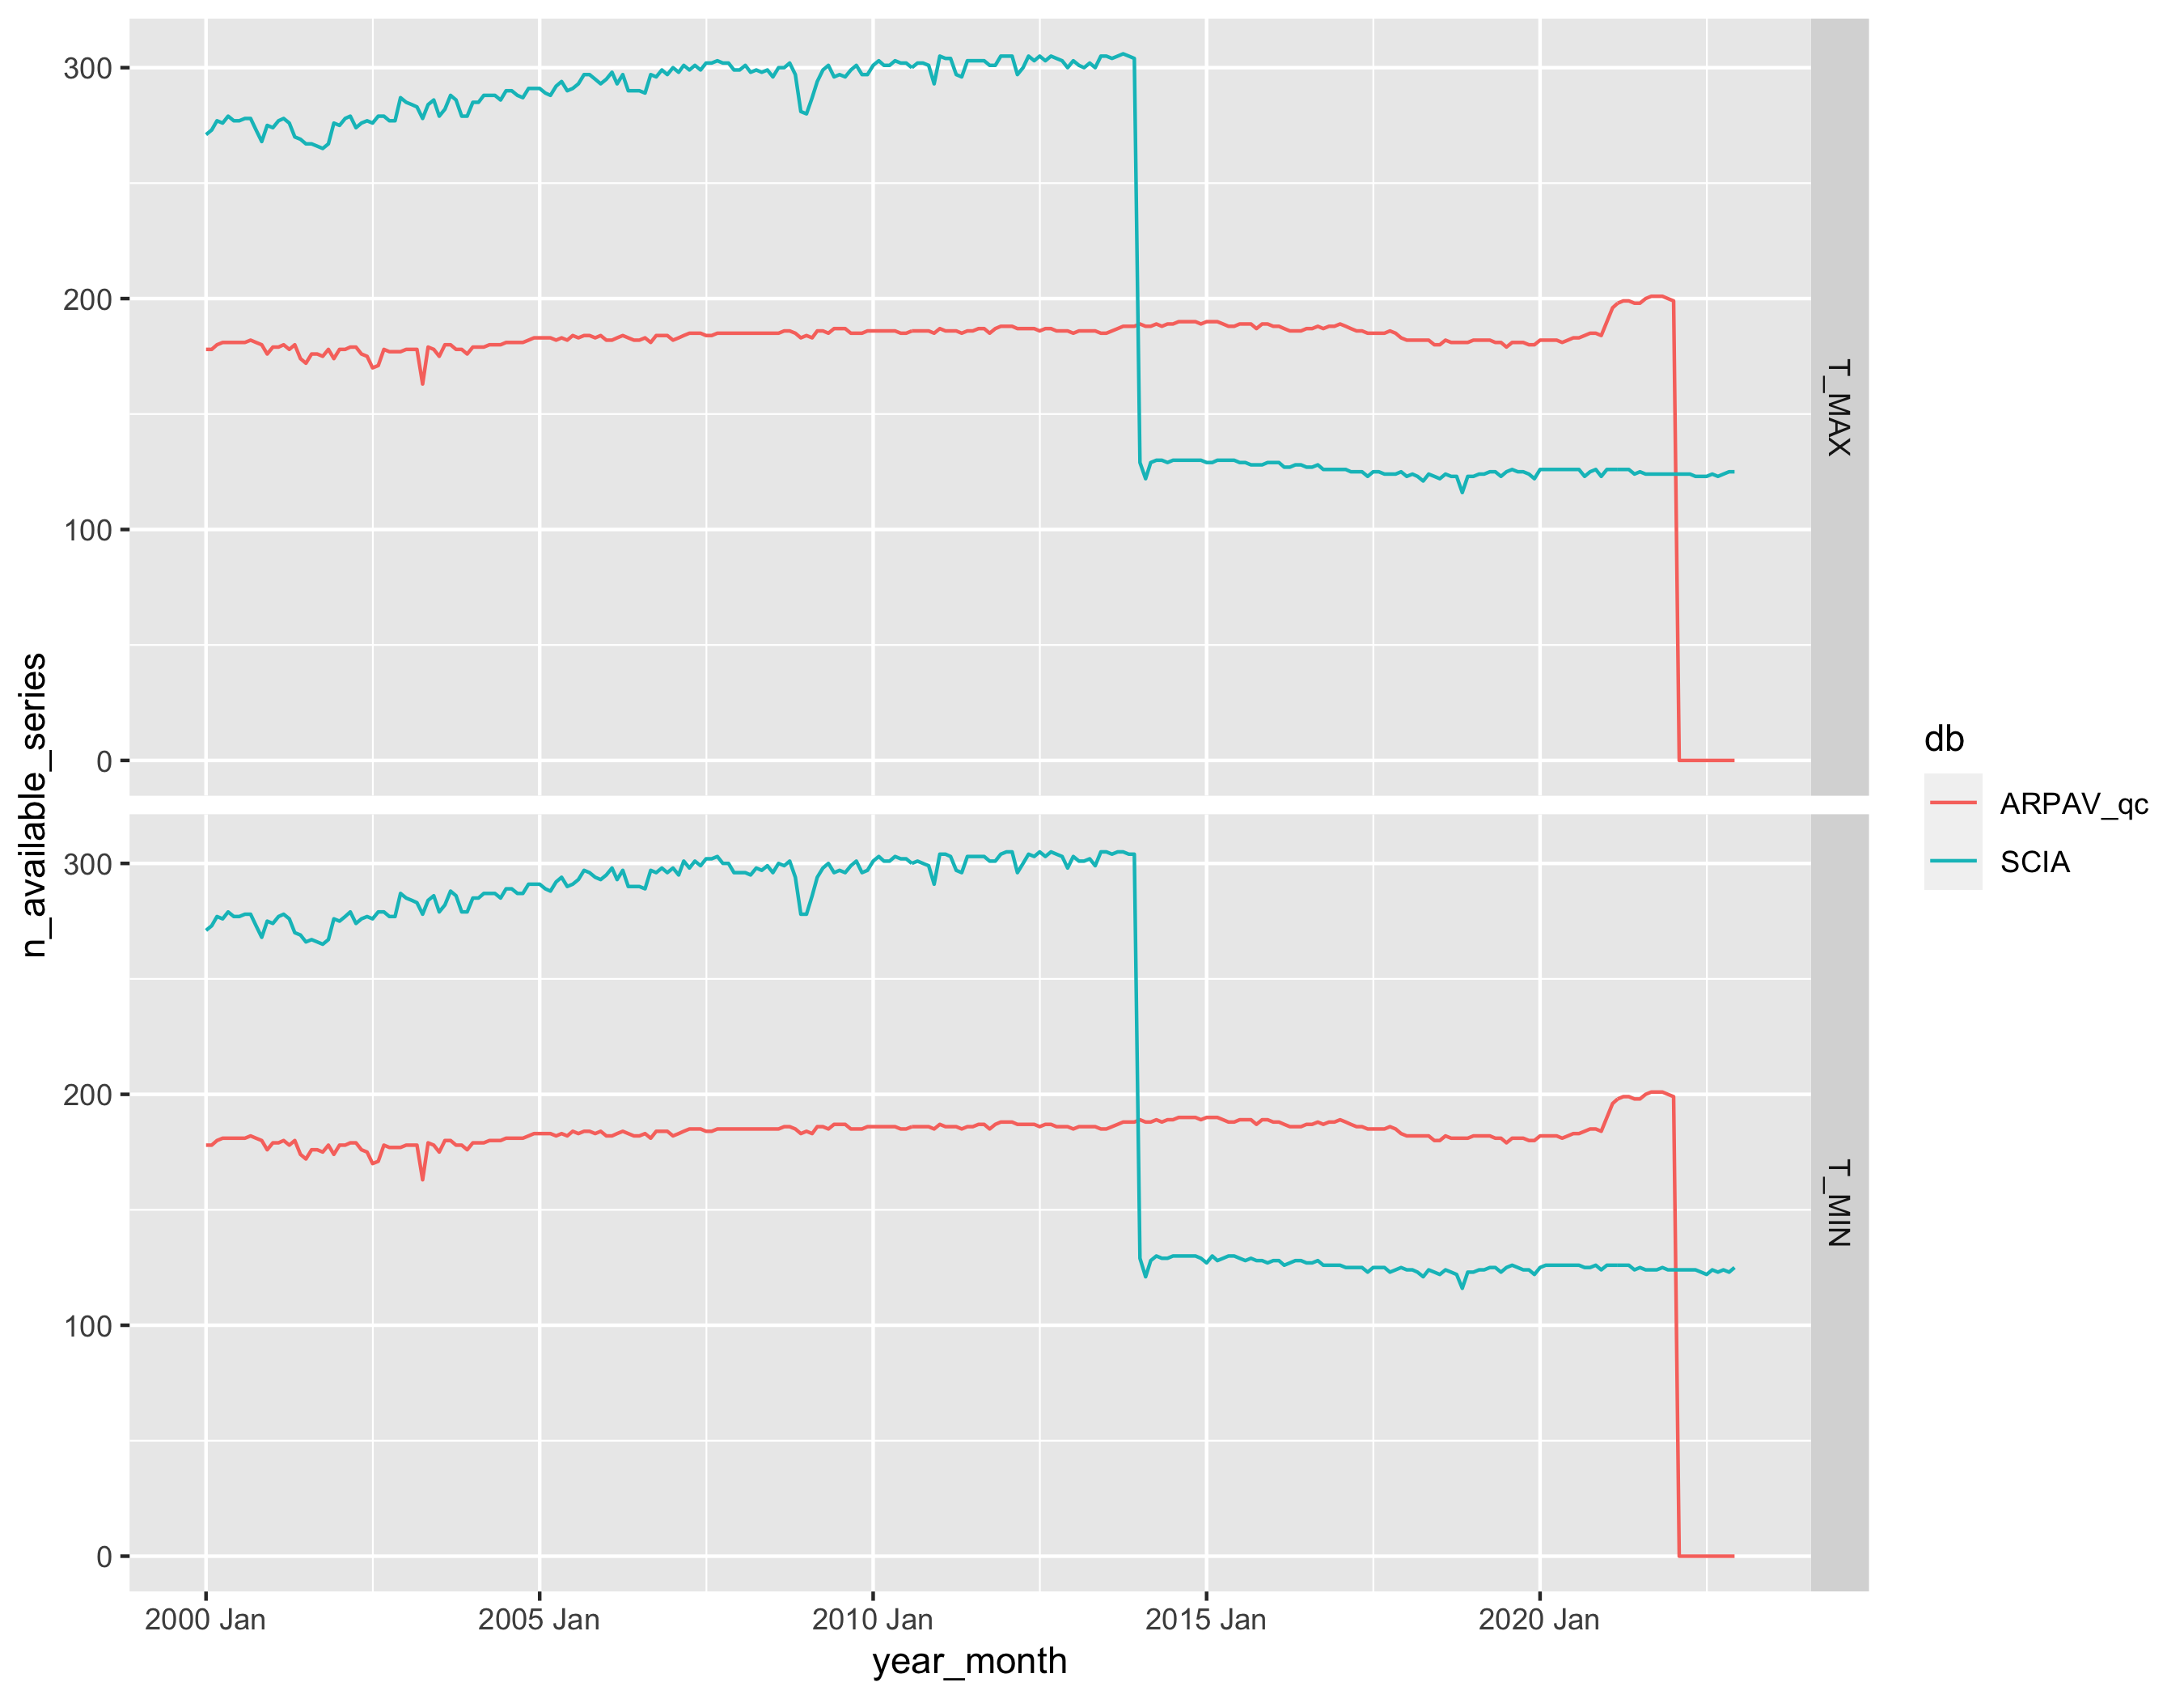

In [67]:
qc_dataset <- paste0(dataset_id, "_qc")

scia_stations <- read_station_metadata("SCIA", FALSE) |> filter(state == "Veneto")
scia_series <- read_series_metadata("SCIA", FALSE) |> semi_join(scia_stations, by = "station_id")
scia_data <- open_data("SCIA", FALSE) |>
    inner_join(scia_series |> select(series_id, variable), by = "series_id") |>
    mutate(db = "SCIA") |>
    relocate(series_id, variable, date, value, merged, db)

state_stations <- read_station_metadata(dataset_id, FALSE)
state_series <- read_series_metadata(qc_dataset, TRUE)
state_data <- open_data(qc_dataset, provisional = TRUE) |>
    left_join(
        state_series |>
            select(series_id, station_id, variable),
        by = "series_id"
    ) |>
    select(series_id, variable, date, value, merged) |>
    mutate(db = qc_dataset)

concat_tables(state_data |> compute(), scia_data |> compute(), unify_schemas = FALSE) |>
    collect() |>
    plot_state_avail(first_date, last_date)


Probabilmente il sovrannumero di stazioni di SCIA viene dalla ripetizione di stazioni attribuendole a reti diverse

In [98]:
scia.meta <- join_metas(scia_stations, scia_series) |> left_join(read_station_extra_metadata("SCIA", FALSE), by = "station_id")
ml <- match_list(scia.meta, scia.meta, 2, TRUE)


In [100]:
ml |>
    left_join(scia.meta |> select(series_id, station_name, network, last_date), join_by(series_id.x == series_id)) |>
    left_join(scia.meta |> select(series_id, station_name, network, last_date), join_by(series_id.y == series_id)) |>
    slice_head(n = 10L) |>
    collect()


series_id.x,series_id.y,match_id,variable,station_name.x,network.x,last_date.x,station_name.y,network.y,last_date.y
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<date>
740e8431b527fb692f23153f12d80914,1eb53f85edba01053746ff62bb1d16a5,3,T_MIN,Adria Bellombra,Regionale ARPA Veneto,2022-12-31,Adria - Bellombra,Idrografica,2013-12-31
ec781dd024817724e3cbe2fd93c0c77b,991a5a080ec1bba56c0ecd745ddc7707,7,T_MIN,Agna,Regionale ARPA Veneto,2022-12-31,Agna,Idrografica,2013-12-31
1aed4a330b2128d63c002909f539d980,d3f294ad6ff464e95ecc1d101d710861,10,T_MIN,Agno a Ponte Brogliano,Idrografica,2013-12-31,Trissino,Idrografica,2013-12-31
1b33bb2878df70ae90d9b69db7f2b6fe,e78b8046e8a602940c06a49dc9d4af82,14,T_MIN,Agordo,Regionale ARPA Veneto,2022-12-31,Agordo,Idrografica,2013-12-31
f999fbae8b168ea2c3b18582c7f40f5f,22c5f1e176681051cd70a2c8a78e29ff,18,T_MIN,Arabba,Regionale ARPA Veneto,2022-12-31,Arabba,Idrografica,2013-12-31
d53222de1ea60ef95cf0200da4c1afbe,6b5cd5584a02137b248c18bc600a65b8,22,T_MIN,Arcole,Regionale ARPA Veneto,2022-12-31,Arcole,Idrografica,2013-12-31
48a4a8bbaa1264e3c38206308576f357,79541c9e45eb9c12d21ad1413222084c,26,T_MIN,Astico a Pedescala,Idrografica,2013-12-31,Astico a Pedescala,Idrografica,2013-12-31
79541c9e45eb9c12d21ad1413222084c,48a4a8bbaa1264e3c38206308576f357,27,T_MIN,Astico a Pedescala,Idrografica,2013-12-31,Astico a Pedescala,Idrografica,2013-12-31
0e00fe2536a43c34b3fbd3eae7866075,6814dbeab4e1ecccb1be5c0f0de48374,31,T_MIN,Auronzo,Regionale ARPA Veneto,2022-12-31,Auronzo,Idrografica,2013-12-31


Infatti c'è una lunga serie di accoppiamenti tra stazioni dell'Idrografica chiuse a fine 2013 e convogliate in ARPAV.

In [104]:
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == state)
climats_comp <- is_climatology_computable(
    as_tsibble(state_data |> collect(), key = c(series_id, variable), index = date),
    value,
    .start = first_date, .end = last_date
) |>
    left_join(state_series |> select(series_id, station_id) |> collect(), by = "series_id") |>
    left_join(state_stations |> select(station_id, lon, lat) |> collect(), by = "station_id") |>
    st_md_to_sf()


Reading layer `geoBoundaries-ITA-ADM1' from data source 
  `/Users/davidenicoli/Local_Workspace/Datasets/geoBoundaries/ITA-ADM1/geoBoundaries-ITA-ADM1.geojson' 
  using driver `GeoJSON'
Simple feature collection with 20 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 6.626621 ymin: 35.49285 xmax: 18.52038 ymax: 47.09178
Geodetic CRS:  WGS 84


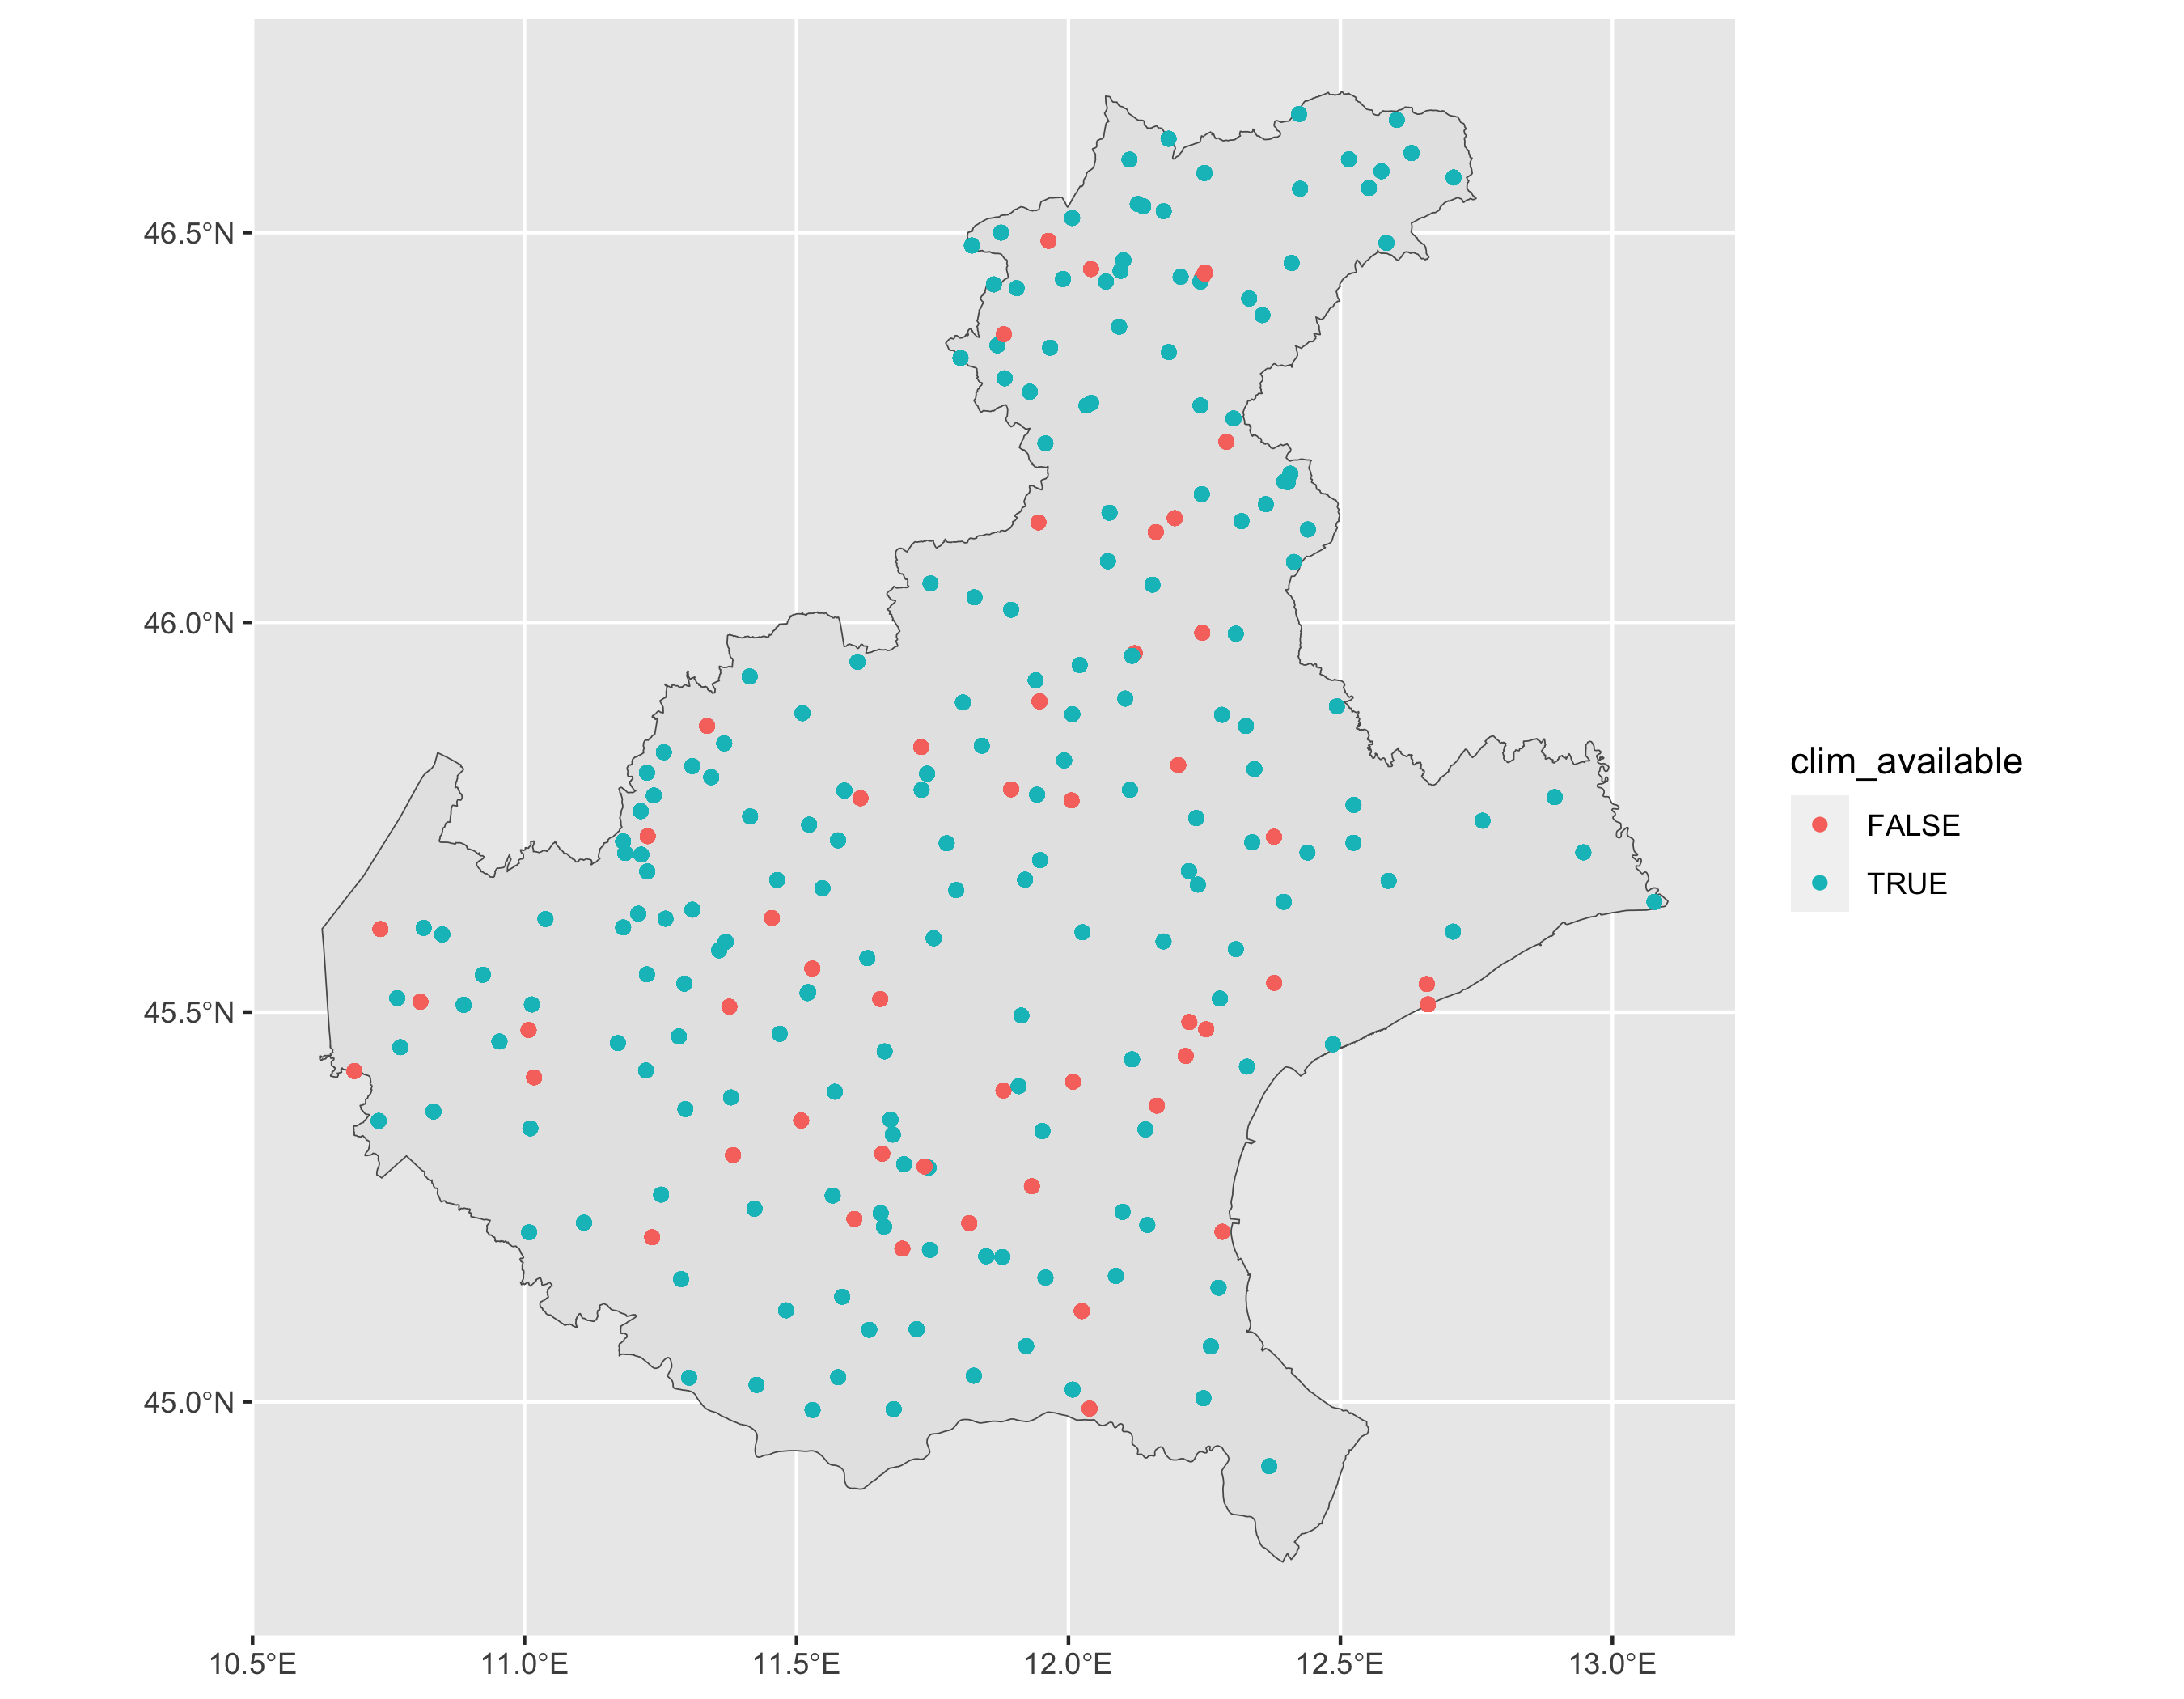

In [108]:
ggplot() + geom_sf(data = state_boundaries) + geom_sf(data = climats_comp, aes(color = clim_available))

## Merging
Gap-filling con altri dataset.
Registrazione dell'esito.

In [110]:
ven.meta <- join_metas(state_stations, state_series)
scia.meta <- join_metas(scia_stations, scia_series)
matches <- match_list(ven.meta, scia.meta, 5)

In [116]:
full_ds <- concat_tables(scia_data |> compute(), state_data |> compute(), unify_schemas = FALSE)
full_meta <- concat_tables(ven.meta, scia.meta, unify_schemas = FALSE)
data.table <- filter_widen_data(full_ds, matches, first_date, last_date)
analysis <- analyze_matches(match_list, data.table, full_meta)

ERROR: Error in UseMethod("select"): su un oggetto di classe "select" `e stato usato un metodo non applicabile per "function"
